## Redes Convolucionales
#### Ejemplo clasificación de perros y gatos para CAPTCHA

Este notebook utiliza datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview). En esta competicion se utiliza Asirra (Animal Species Image Recognition for Restricting Access), CAPTCHA que sirve para diferenciar entre una persona o una máquina accediendo a una página web. Este tipo de "pruebas" se utilizan para evitar emails de spam, y ataques por fuerza bruta contra servidores.

En este notebook vamos a probar que hay técnicas de clasificado automáticas de imágenes mediante redes neuronales, que con las que se intenta saltar CAPTCHA

# Import Library

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Define Constants
Tendremos una serie de constantes como las dimensiones de las imágenes, que serán fijas a lo largo de todo el notebook

In [3]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 10
EPOCHS = 5

TRAIN_PATH = "train\\"

# Prepare Training Data
1. Descárgate el dataset de train de [la competición de Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview).
2. Descomprime el dataset y guardalo en la ruta que quieras del ordenador. Por supuesto, NO en la carpeta donde esté el repositorio

A partir de los ficheros de perros y gatos, crea un dataframe `df` como este:   

| filename     | category |
|--------------|----------|
| cat.0.jpg    | 0        |
| cat.1.jpg    | 0        |
| ...          | ...      |
| dog.9999.jpg | 1        |

In [14]:
filenames = os.listdir(TRAIN_PATH)
df = pd.DataFrame()
category = [0 if 'cat' in file else 1 for file in filenames]
df['filename'] = filenames
df['category'] = category
df

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


¿El dataset está balanceado?

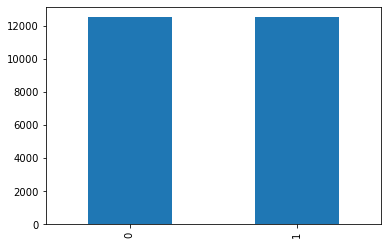

In [16]:
df['category'].value_counts().plot.bar();

# Imagen de muestra

In [ ]:
#!pip install opencv-python 

(374, 500, 3)
247


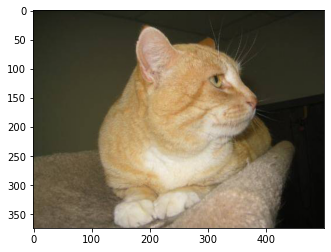

In [33]:
'''
Tres canales para el RGB.
Todas las imagágenes en diferentes resoluciones. Esto es un problema.
Todas tienen que llevar las mismas dimensiones para la entrada a la red
'''
from skimage.io import imread
# pip install opencv-python 
import cv2

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)

print(image.shape)
print(np.max(image))
plt.imshow(image);

Una imagen no es mas que un array de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. 

In [38]:
image

array([[[26, 27, 21],
        [26, 27, 21],
        [26, 27, 21],
        ...,
        [26, 27, 19],
        [26, 27, 19],
        [26, 27, 19]],

       [[26, 27, 21],
        [26, 27, 21],
        [26, 27, 21],
        ...,
        [26, 27, 19],
        [26, 27, 19],
        [26, 27, 19]],

       [[26, 27, 21],
        [26, 27, 21],
        [26, 27, 21],
        ...,
        [26, 27, 19],
        [26, 27, 19],
        [26, 27, 19]],

       ...,

       [[99, 86, 67],
        [97, 84, 65],
        [96, 83, 64],
        ...,
        [ 6,  6,  4],
        [ 6,  6,  4],
        [ 6,  6,  4]],

       [[94, 81, 62],
        [95, 82, 63],
        [96, 83, 64],
        ...,
        [ 6,  6,  4],
        [ 6,  6,  4],
        [ 6,  6,  4]],

       [[89, 76, 57],
        [93, 80, 61],
        [95, 82, 63],
        ...,
        [ 6,  6,  4],
        [ 6,  6,  4],
        [ 6,  6,  4]]], dtype=uint8)

# Resize image
Cargar todas las imágenes a la vez es un problema ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un resize a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

Tamaño imagen original: (375, 499, 3)
Tamaño imagen reshape: (32, 32, 3)
Maximo valor por pixel: 202


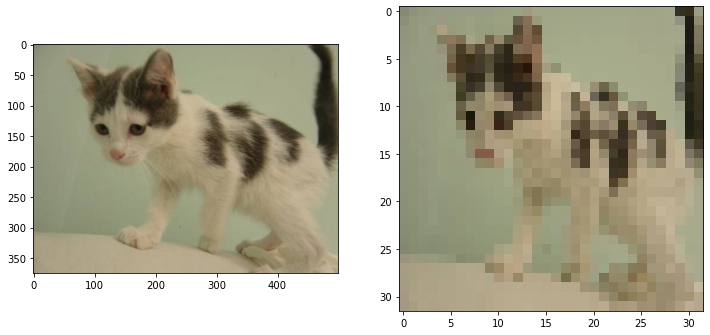

In [40]:
plt.figure(figsize=(12, 12))

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)
print("Maximo valor por pixel:", np.max(imagesmall))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall);

# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

Dimensiones: (374, 500)
Maximo color: 255


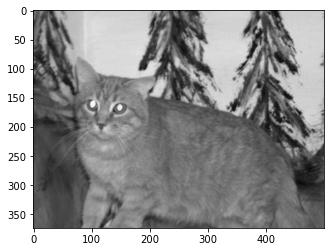

In [41]:
sample = random.choice(filenames)

image = cv2.imread(filename=TRAIN_PATH + sample, flags=cv2.IMREAD_GRAYSCALE)

print("Dimensiones:", image.shape)
print("Maximo color:", np.max(image))
plt.imshow(image,cmap='gray');

# Load data
Llega el momento de cargar los datos. Ya no estan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [ ]:
np.random.choice(os.listdir(TRAIN_PATH), size = 10)

In [42]:
def read_data(path, im_size, sample_size):
    X = []
    Y = []
    
    pics = np.random.choice(os.listdir(path), size = sample_size)
    
    for file in pics:
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        X.append(smallimage)
        
        category = file.split('.')[0]
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)

    return np.array(X), np.array(Y)
    

Utiliza la función `read_data` para cargar 5000 imágenes de entrenamiento y 500 de test en las variables `X_train`, `y_train`, `X_test`, `y_test`

In [43]:
X,Y = read_data(TRAIN_PATH, IMAGE_SIZE, 5500)


In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=10,test_size=500,stratify=Y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5000, 32, 32, 3)
(500, 32, 32, 3)
(5000,)
(500,)


In [60]:
pd.DataFrame(y_train).value_counts(normalize=True)

0    0.511
1    0.489
dtype: float64

In [61]:
pd.DataFrame(y_test).value_counts(normalize=True)

0    0.512
1    0.488
dtype: float64

Haz un plot de la primera imagen del conjunto de test

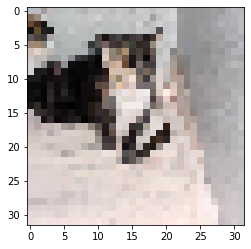

In [52]:
plt.imshow(X_test[0])

In [62]:
X_test[0].shape

(32, 32, 3)

# Normalized data
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

In [63]:
print('Min:',np.min(X_train))
print('Max:',np.max(X_train))

Min: 0
Max: 255


In [64]:
X_train = X_train/255.0
X_test = X_test/255.0

print('Min:',np.min(X_train))
print('Max:',np.max(X_train))

Min: 0.0
Max: 1.0


# Shuffle data
Como hemos cargado los datos de manera ordenada (primero gatos y luego perros), tendremos que desordenarlos para asegurarnos de que no haya ningún sesgo en el entrenamiento ni en la selección de datos de validación.

In [65]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [ ]:
np.savez('data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Para cargar

In [ ]:
data = np.load('data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la metrica, se puede usar un binary_crossentropy, al ser un target binario.

Implementa una red neuronal convolucional con las siguientes capas:  

- Tres capas convolucionales con 32, 64 y 128 kernels (respectivamente) de tamaño 3x3 y activación reLU

Después de cada capa convolutiva, añade: 

- Una capa max pooling 2x2
- Una capa dropout de 0.25

Por último, aplana la red y añade:

- Una capa densa de 512 neuronas y activación reLU
- Una capa Dropout de 0.5
- Una capa de salida 

Compila la red con el optimizador adam y muestra la métrica de accuracy


In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu',
                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

'''
También podríamos haber usado dos neuronas de salida.
Para ello hay que pasar la "y" a one-hot-encoding usando 

from keras.utils import to_categorical
y_train = to_categorical(y_train)

La capa de salida sería:
model.add(Dense(2, activation='softmax'))

Si tuviera 3 o más clases tendría que usar esta opción
'''

model.compile(optimizer='adam', loss='binary_crossentropy',
             metrics=['accuracy'])

In [66]:
y_train

array([0, 1, 0, ..., 0, 1, 1])

# Fit the model

Entrena el modelo con 5 épocas, tamaño 10 de batch y 20% de split para validación

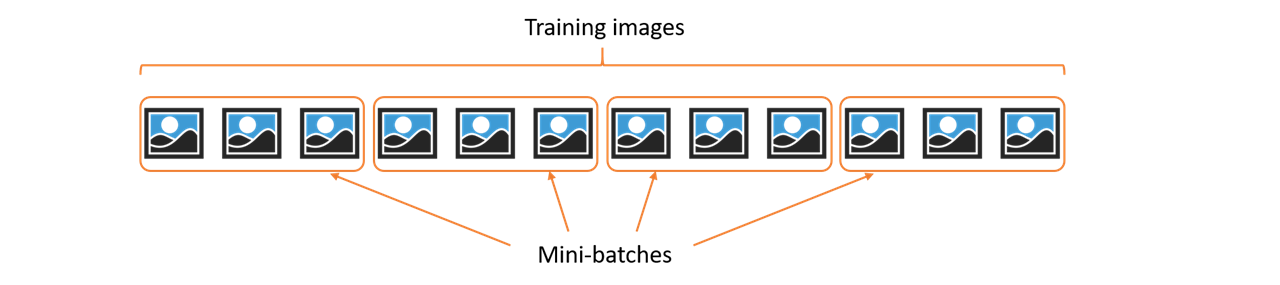

In [71]:
history = model.fit(X_train,y_train,epochs=10,
                   batch_size=BATCH_SIZE,
                   validation_split=0.2)

Epoch 1/10
400/400 [==============================] - 24s 61ms/step - loss: 0.5809 - accuracy: 0.7010 - val_loss: 0.5958 - val_accuracy: 0.6760
Epoch 2/10
400/400 [==============================] - 18s 44ms/step - loss: 0.5645 - accuracy: 0.7082 - val_loss: 0.5680 - val_accuracy: 0.7000
Epoch 3/10
400/400 [==============================] - 10s 25ms/step - loss: 0.5397 - accuracy: 0.7243 - val_loss: 0.5826 - val_accuracy: 0.6760
Epoch 4/10
400/400 [==============================] - 4s 10ms/step - loss: 0.5160 - accuracy: 0.7362 - val_loss: 0.5630 - val_accuracy: 0.7110
Epoch 5/10
400/400 [==============================] - 5s 14ms/step - loss: 0.4903 - accuracy: 0.7630 - val_loss: 0.5377 - val_accuracy: 0.7280
Epoch 6/10
400/400 [==============================] - 9s 24ms/step - loss: 0.4792 - accuracy: 0.7648 - val_loss: 0.5292 - val_accuracy: 0.7420
Epoch 7/10
400/400 [==============================] - 4s 10ms/step - loss: 0.4708 - accuracy: 0.7763 - val_loss: 0.5373 - val_accuracy: 0.7

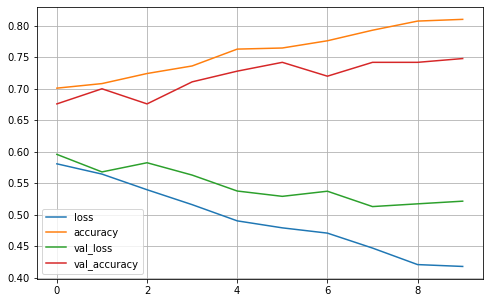

In [72]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

# Evaluate
Probemos los datos en el conjunto de test.

In [73]:
results = model.evaluate(X_test,y_test)
print("test loss, test accuracy", results)

16/16 [==============================] - 0s 4ms/step - loss: 0.5337 - accuracy: 0.7420
test loss, test accuracy [0.5337375998497009, 0.7419999837875366]


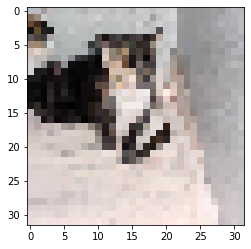

In [74]:
plt.imshow(X_test[0])

¿Qué predice el modelo para la imagen anterior?

In [77]:
model.predict(X_test[0])

ValueError: in user code:

    C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\keras\engine\input_spec.py:229 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (32, 32, 3)


Al haber entrenado con mini-batches, la entrada a la red es un tensor de tamaño `[batch_size, image_width, image_height, number_of_channels]`  
Al predecir, tenemos que respetar este tamaño aunque solo usemos una imagen. Puedes expandir la dimensión con la función de numpy `expand_dims`

In [78]:
X_test[0].shape

(32, 32, 3)

In [79]:
np.expand_dims(X_test[0], axis=0).shape

(1, 32, 32, 3)

In [80]:
model.predict(np.expand_dims(X_test[0], axis=0))

array([[0.45069775]], dtype=float32)

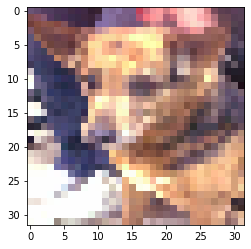

In [85]:
plt.imshow(X_test[9])

¿Qué predice la red para la imagen anterior?

In [86]:
model.predict(np.expand_dims(X_test[9], axis=0))

array([[0.709247]], dtype=float32)

# Image data generator

In [87]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

Categorias: ['cat' 'dog']


,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [95]:
example_df = df.sample(n=1).reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
)

Found 1 validated image filenames belonging to 1 classes.


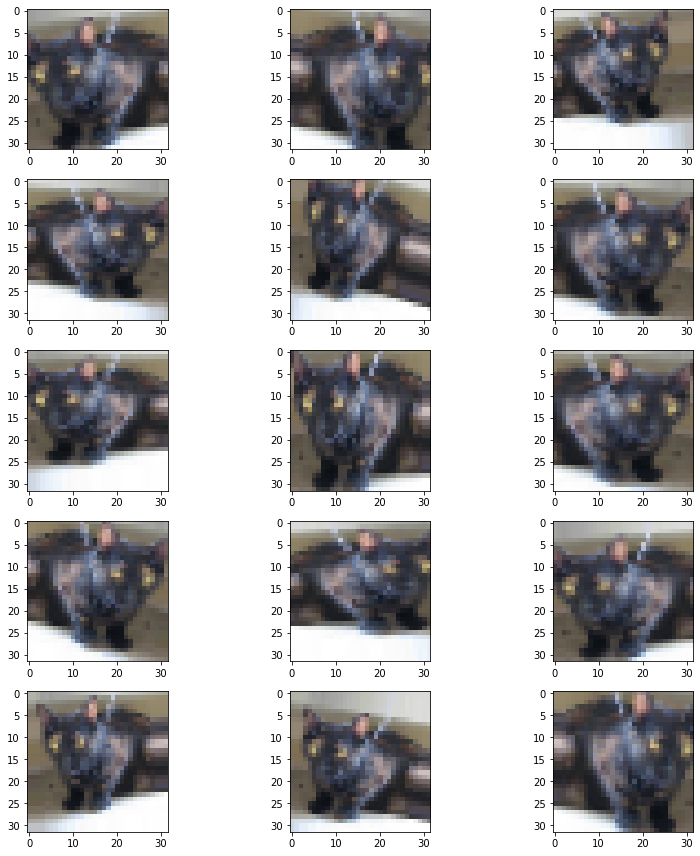

In [96]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [97]:
train_df, validate_df = train_test_split(df.sample(5500),
                                         test_size=500,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [98]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 5000
Shape validation 500


,filename,category
0,dog.1807.jpg,dog
1,cat.2857.jpg,cat
2,cat.1215.jpg,cat
3,cat.6231.jpg,cat
4,dog.2513.jpg,dog


In [99]:
train_df.head()

,filename,category
0,cat.5398.jpg,cat
1,cat.3321.jpg,cat
2,dog.6416.jpg,dog
3,dog.2003.jpg,dog
4,dog.9255.jpg,dog


In [100]:
train_df.category.value_counts()

dog    2533
cat    2467
Name: category, dtype: int64

# Training Generator

In [101]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


### Validation Generator

In [103]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


# Fit Model

In [104]:
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/5
500/500 [==============================] - 70s 139ms/step - loss: 0.5981 - accuracy: 0.6780 - val_loss: 0.5039 - val_accuracy: 0.7518
Epoch 2/5
500/500 [==============================] - 54s 108ms/step - loss: 0.5814 - accuracy: 0.6996 - val_loss: 0.5156 - val_accuracy: 0.7456
Epoch 3/5
500/500 [==============================] - 50s 99ms/step - loss: 0.5807 - accuracy: 0.6954 - val_loss: 0.5022 - val_accuracy: 0.7504
Epoch 4/5
500/500 [==============================] - 49s 98ms/step - loss: 0.5670 - accuracy: 0.7098 - val_loss: 0.5138 - val_accuracy: 0.7450
Epoch 5/5
500/500 [==============================] - 52s 103ms/step - loss: 0.5719 - accuracy: 0.7076 - val_loss: 0.4746 - val_accuracy: 0.7846


In [105]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

16/16 [==============================] - 0s 7ms/step - loss: 0.4828 - accuracy: 0.7760
test loss, test acc: [0.48278188705444336, 0.7760000228881836]


## Guardar el modelo

In [ ]:
model.save_weights("model.h5")

## Predecir nuevas imágenes

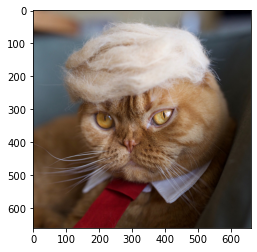

In [106]:
image = imread('gato.jpg')
plt.imshow(image);

In [107]:
image = np.array([cv2.resize(image,(IMAGE_WIDTH,IMAGE_HEIGHT))/255.0])

In [108]:
image.shape

(1, 32, 32, 3)

In [111]:
model.predict(image)

array([[0.38645357]], dtype=float32)